* Play a little with KG embedding learning from semmed kg.
* Note: `Subject : Predicate -> Object`

  * PyKeen , DL-KGE...
* https://pykeen.github.io/2020/08/07/benchmarking.html
    * rotatE, TuckER, TransE - do well
 
Relevant other paper did Trans-E on semmed : *"Evaluating Explanations from AI Algorithms for Clinical Decision-Making: A Social Science-based Approach"*


* pyKeen + curie biomed text represntations from entities to text (e.g. for transformer text rep) ; https://pykeen.readthedocs.io/en/stable/api/pykeen.nn.representation.BiomedicalCURIERepresentation.html#pykeen.nn.representation.BiomedicalCURIERepresentation

* * Load Pretrained models/representation, e.g. cui2vec : https://github.com/pykeen/pykeen/issues/637
  *  load init - https://pykeen.readthedocs.io/en/v1.8.1/reference/nn/init.html

In [ ]:
MIN_EVIDENCE = 7#5 # filter counts/num of cases /pmids it appeared in - proxy to reduce noise
MIN_ENT_FREQ = 170#140#210 # keep only cases with this many occurrences

# MIN_EVIDENCE = 9#5
# MIN_ENT_FREQ = 350

REMOVE_NEG_PREDICATES = True # remove predicates containnig "neg" as I don't know if we want them for now

In [1]:
import pandas as pd
import numpy as np
## scispacy, medspacy, medcat, quickumls, semrep...
# import spacy

In [2]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE
from pykeen.triples import TriplesFactory
# from pykeen.models.predict import get_tail_prediction_df
# https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target
from pykeen.predict import predict_target

# # https://pykeen.readthedocs.io/en/latest/tutorial/inductive_lp.html#label-based-transformer-representation
# ### "This is work in progress and not yet available." # pykeen.nn.representation import LabelBasedTransformerRepresentation

## https://pykeen.readthedocs.io/en/latest/api/pykeen.nn.init.LabelBasedInitializer.html
## Initialize entity representations as Transformer encodings of their labels. 
from pykeen.nn.init import LabelBasedInitializer
from pykeen.models import ERMLPE

import torch
import gc
torch.cuda.empty_cache()
gc.collect()

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


0

In [3]:
# !python -m pykeen version

In [4]:
from pykeen.datasets import get_dataset
from pykeen.models import ERModel, RotatE, TransR
from pykeen.nn.init import LabelBasedInitializer
from pykeen.pipeline import pipeline

# dataset = get_dataset(dataset="nations", dataset_kwargs=dict(create_inverse_triples=True))
# entity_initializer = LabelBasedInitializer.from_triples_factory(
#     triples_factory=dataset.training,
#     for_entities=True,
# )

# results = pipeline(
#     dataset=dataset,
#     # training=training,
#     # testing=testing,
#     # validation=validation,
#     model="distmult",
#     epochs=11,
#     evaluation_fallback = True,
#     stopper='early',
#     # device="mps",
# )


0it [00:00, ?it/s]

No random seed is specified. Setting to 2490510728.
No cuda devices were available. The model runs on CPU
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cpu:   0%|          | 0/13 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/13 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/13 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/13 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/13 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/201 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity Plot using PCA'}>], dtype=object))

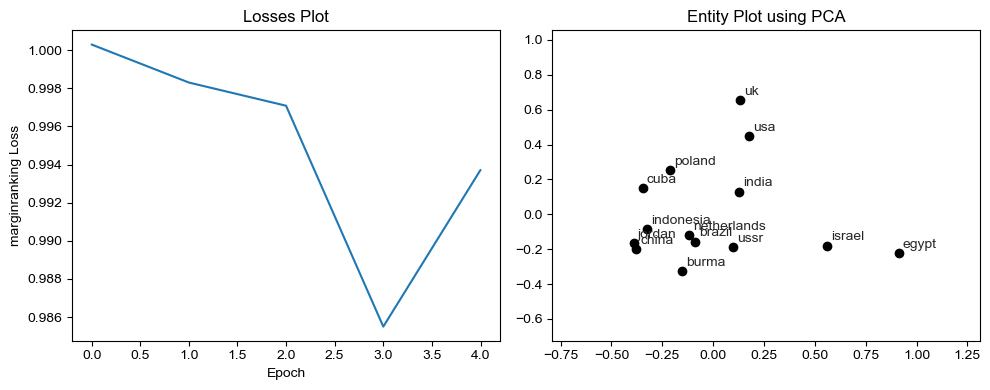

In [5]:
# !pip install torch_geometric 

from pykeen.datasets import get_dataset
from pykeen.models import ERModel, RotatE, TransR
from pykeen.nn.init import LabelBasedInitializer
from pykeen.pipeline import pipeline

dataset = get_dataset(dataset="nations", dataset_kwargs=dict(create_inverse_triples=True))
entity_initializer = LabelBasedInitializer.from_triples_factory(
    triples_factory=dataset.training,
    for_entities=True,
)


# ## use transformer:
# entity_initializer=LabelBasedInitializer.from_triples_factory(
#         triples_factory=dataset.training,
#         encoder="transformer",
#     for_entities=True, # added
#     ),

(embedding_dim,) = entity_initializer.tensor.shape[1:] # not work with using transformer init


r = pipeline(
    # device="mps", ## crashes on mac
    stopper='early', # added
    dataset=dataset,
    model=ERModel,

    model_kwargs=dict(
        # interaction= "RESCAL", #"distmult", - default
        interaction= "distmult", #- default
        entity_representations="SimpleMessagePassing",
        entity_representations_kwargs=dict(
            triples_factory=dataset.training,
            base_kwargs=dict(
                shape=embedding_dim,
                initializer=entity_initializer,
                trainable=False,
            ),
            layers=["GCN"] * 1, ## was 2
            layers_kwargs=dict(in_channels=embedding_dim, out_channels=embedding_dim),
        ),
        relation_representations_kwargs=dict(
            shape=embedding_dim,
        ),
    ),
)

r.plot()

In [6]:
# ## load saved chkpoint from pykeen dir
# ## https://pykeen.readthedocs.io/en/stable/tutorial/checkpoints.html
# import torch
# from pykeen.constants import PYKEEN_CHECKPOINTS
# from pykeen.pipeline import pipeline
# from pykeen.triples import TriplesFactory
# # checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath('my_checkpoint.pt'))

# # ## more styeps

# # from pykeen.models import TransE
# # my_model = TransE(triples_factory=train)
# # my_model.load_state_dict(checkpoint['model_state_dict'])

In [8]:
df_kg = pd.read_parquet("predications.parquet")

if REMOVE_NEG_PREDICATES:
    df_kg = df_kg.loc[~df_kg["PREDICATE"].str.contains("neg_",case=False)]
df_kg

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,counts
2101,C0087111,Therapeutic procedure,topp,TREATS,False,C0030705,Patients,podg,False,151392
747,C0040395,tomography,diap,USES,True,C1441526,COMPUTED,lbpr,False,143421
3274,C0012634,Disease,dsyn,PROCESS_OF,False,C0030705,Patients,humn,False,136269
5161,C0543467,Operative Surgical Procedures,topp,TREATS,True,C0030705,Patients,podg,False,104032
33,C1457887,Symptoms,sosy,PROCESS_OF,False,C0030705,Patients,humn,False,86269
...,...,...,...,...,...,...,...,...,...,...
101678940,1,A1BG,gngm,AFFECTS,False,C0036421,Systemic Scleroderma,dsyn,True,1
69169934,1,A1BG,gngm,AFFECTS,True,C0028754,Obesity,dsyn,True,1
29880800,1,A1BG,aapp,AFFECTS,True,C0020291,Hydrolysis,npop,True,1
66983871,1,A1BG,gngm,AFFECTS,True,C0005935,Bone Conduction,ortf,True,1


In [9]:
df_kg.PREDICATE.value_counts()

PREDICATE
LOCATION_OF           3560376
AFFECTS               2524462
COEXISTS_WITH         2177057
INTERACTS_WITH        2160079
TREATS                1903582
                       ...   
NEG_OCCURS_IN               0
NEG_METHOD_OF               0
NEG_MEASURES                0
NEG_MEASUREMENT_OF          0
NEG_LOCATION_OF             0
Name: count, Length: 63, dtype: int64

In [10]:
%%time
print(df_kg.shape[0]) # 26M
df_kg = df_kg.loc[df_kg["counts"]>=MIN_EVIDENCE].copy()
print("After filtering min count",df_kg.shape[0])
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
 & (df_kg.groupby("PREDICATE").transform("size")>4*MIN_ENT_FREQ)].copy()
print("After filtering entity count 1",df_kg.shape[0])
for c in df_kg.select_dtypes("category").columns:
# remove unobserved categories, in new filtered data
    df_kg[c] = df_kg[c].cat.remove_unused_categories()
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>4*MIN_ENT_FREQ)].copy()
print("After filtering entity count 2",df_kg.shape[0])
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_NAME").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_NAME").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>4*MIN_ENT_FREQ)].copy()
print("After filtering entity names count 3",df_kg.shape[0])
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_NAME").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_NAME").transform("size")>MIN_ENT_FREQ\
                                                                                   ) & (df_kg.groupby("PREDICATE").transform("size")>4*MIN_ENT_FREQ)].copy()
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_NAME").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_NAME").transform("size")>MIN_ENT_FREQ\
                                                                                   ) & (df_kg.groupby("PREDICATE").transform("size")>4*MIN_ENT_FREQ)].copy()

print("After filtering entity names count 4",df_kg.shape[0])
for c in df_kg.select_dtypes("category").columns:
# remove unobserved categories, in new filtered data
    df_kg[c] = df_kg[c].cat.remove_unused_categories()
print(df_kg.shape[0]) # 4M
print(df_kg.nunique())

25677725
After filtering min count 1901620
After filtering entity count 1 567149


<timed exec>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

After filtering entity count 2 410566
After filtering entity names count 3 287034
After filtering entity names count 4 213760
213760
SUBJECT_CUI         618
SUBJECT_NAME        680
SUBJECT_SEMTYPE      67
PREDICATE            24
SUBJECT_NOVELTY       2
OBJECT_CUI          573
OBJECT_NAME         607
OBJECT_SEMTYPE       64
OBJECT_NOVELTY        2
counts             2654
dtype: int64
CPU times: user 282 ms, sys: 53.7 ms, total: 336 ms
Wall time: 305 ms


<timed exec>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

In [12]:
df_kg["PREDICATE"].value_counts()

PREDICATE
AFFECTS            31011
LOCATION_OF        21390
TREATS             20294
PART_OF            15157
ASSOCIATED_WITH    14539
INTERACTS_WITH     13786
COEXISTS_WITH      12993
CAUSES             11843
STIMULATES         10531
PROCESS_OF          9626
AUGMENTS            8363
DISRUPTS            6284
INHIBITS            6272
PREDISPOSES         6001
ADMINISTERED_TO     5310
PRODUCES            4866
PREVENTS            4101
compared_with       2259
USES                1862
ISA                 1750
MEASURES            1649
DIAGNOSES           1544
OCCURS_IN           1437
PRECEDES             892
Name: count, dtype: int64

In [13]:
## "novelty" look?
## partial mini list. Not exhaustive
subsetPredicates = {"AFFECTS","TREATS","PREVENTS","INHIBITS","DISRUPTS","INTERACTS_WITH","PREDISPOSES","PREVENTS",
                    "CAUSES","STIMULATES","AUGMENTS","PREDISPOSES","PRECEDES",
                    "NEG_TREATS","NEG_AFFECTS","NEG_PROCESS_OF","NEG_ISA","NEG_ASSOCIATED_WITH","NEG_CAUSES"} # made into set instead of list


if REMOVE_NEG_PREDICATES:
    subsetPredicates = [x for x in subsetPredicates if "NEG" not in x]

# df_kg.loc[df_kg["SUBJECT_NOVELTY"] | df_kg["OBJECT_NOVELTY"]].head(10)
df_kg.loc[(df_kg["OBJECT_NOVELTY"]) & (df_kg["PREDICATE"].isin(subsetPredicates))].head(4)

# subsetPredicates = dict(subsetPredicates)

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,counts
33506,C0087111,Therapeutic procedure,topp,TREATS,False,C0008059,Child,aggp,True,13941
52844,C0087111,Therapeutic procedure,topp,TREATS,False,C0006826,Malignant Neoplasms,neop,True,9681
7860,C0087111,Therapeutic procedure,topp,TREATS,False,C0034693,Rattus norvegicus,mamm,True,7771
6059,C0087111,Therapeutic procedure,topp,TREATS,False,C0043210,Woman,popg,True,7214
457,C0087111,Therapeutic procedure,topp,TREATS,False,C0026809,Mus,mamm,True,6507
45596,C0543467,Operative Surgical Procedures,topp,TREATS,True,C0008059,Child,aggp,True,6227
18581,C0007222,Cardiovascular Diseases,dsyn,CAUSES,True,C0011065,Cessation of life,orgf,True,6142
4219,C1273869,Intervention regimes,hlca,TREATS,False,C0008059,Child,humn,True,5568
37643,C0087111,Therapeutic procedure,topp,TREATS,False,C0006142,Malignant neoplasm of breast,neop,True,5426
7107,C0034618,Radiation therapy,topp,TREATS,True,C0006826,Malignant Neoplasms,neop,True,5313


In [14]:
# df_kg.loc[(df_kg["OBJECT_NOVELTY"]) & (df_kg["PREDICATE"].isin(subsetPredicates))].drop_duplicates("SUBJECT_NAME").sample(11)

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,counts
146365,C0003009,Angiotensin II,phsu,TREATS,True,C0034693,Rattus norvegicus,mamm,True,1185
905483,C0024432,macrophage,cell,AFFECTS,True,C0043240,Wound Healing,orgf,True,278
526861,C0011581,Depressive disorder,mobd,AFFECTS,True,C0043210,Woman,humn,True,244
4219,C1273869,Intervention regimes,hlca,TREATS,False,C0008059,Child,humn,True,5568
4739680,C0596981,Muscle Cells,cell,INTERACTS_WITH,True,C0021641,Insulin,gngm,True,26
8874,C0694888|5728,PTEN gene|PTEN,gngm,STIMULATES,True,C0031727,Phosphotransferases,gngm,True,381
103279797,C0020281,hydrogen peroxide,inch,CAUSES,True,C0242606,Oxidative Stress,comd,True,1636
246381,C0021246,Indomethacin,phsu,TREATS,True,C0034693,Rattus norvegicus,mamm,True,862
6267,C0011900,Diagnosis,hlca,TREATS,False,C0008059,Child,humn,True,2978
96554,C0596473,Early Diagnosis,diap,AFFECTS,True,C0006826,Malignant Neoplasms,neop,True,44


* Training - assumption of LCWA
* https://pykeen.readthedocs.io/en/stable/reference/training.html#local-closed-world-assumption
* hetionet example inc loading ,eval: https://github.com/tomasonjo/blogs/blob/master/pykeen/Hetionet%20-%20RotatE.ipynb

* mps -> memory issues/crashes?

* Another example pykeen : https://pykeen.readthedocs.io/en/stable/tutorial/first_steps.html
* RotatE seems good from lit, on hetionet
* pubmedKG for text/sentencetransformer embedding?
* GCN https://pykeen.readthedocs.io/en/stable/reference/nn/pyg_message_passing.html

In [15]:
# print(1e3*(df_kg.shape[0]//1e3))
# print('{:.2E}'.format(df_kg.shape[0]))
print(df_kg.shape[0])

213760


In [40]:
%%time
from pykeen.nn import TextRepresentation
## https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

### load new data example: https://towardsdatascience.com/knowledge-graph-completion-with-pykeen-and-neo4j-6bca734edf43
# .astype("category")
tf = TriplesFactory.from_labeled_triples(
  df_kg.rename(columns={"SUBJECT_NAME":"source",
                        "PREDICATE":"type",
                        "OBJECT_NAME":"target"})[["source", "type", "target"]].values ,
)

CPU times: user 225 ms, sys: 24.5 ms, total: 249 ms
Wall time: 227 ms


In [41]:
# training, testing, validation = tf.split([.9, .05, .05])
training, testing, validation = tf.split([.8, .1, .1])

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [168061, 21120, 21121]


In [42]:
## try new 
entity_initializer = LabelBasedInitializer.from_triples_factory(
    triples_factory=training,
    for_entities=True,
    encoder="transformer",
     # model_kwargs=dict(device="mps") # doesn't work
)


### https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

0it [00:00, ?it/s]

* Another text-kg example code inc triples:
    * https://gist.github.com/airysen/2b4f8b5dff8cc72b8951d4457228a7bd
Example of using LM embeddings in pykeen
```

from pykeen.training import SLCWATrainingLoop
from pykeen.datasets import get_dataset
from pykeen.nn.representation import TextRepresentation
from pykeen.models import ERModel

from pykeen.pipeline import pipeline

from torch.optim import Adam


dataset = get_dataset(dataset="nations")
entity_representations = TextRepresentation.from_triples_factory(
    triples_factory=dataset.training,
    encoder="transformer",
    encoder_kwargs=dict(pretrained_model_name_or_path="bert-base-multilingual-uncased", max_length=512)
)


model = ERModel(
    triples_factory=dataset.training,
    interaction="ermlpe",
    entity_representations=entity_representations,
    relation_representations_kwargs=dict(shape=entity_representations.shape),
    interaction_kwargs=dict(embedding_dim=entity_representations.shape[0], input_dropout=0.1, hidden_dim=256, hidden_dropout=0.2),
    entity_representations_kwargs=dict(max_length=512),
    random_seed=42,
    # relation_representations_kwargs=dict(embedding_dim=3, dropout=0.1),
)


```

In [45]:
# entity_representations = TextRepresentation.from_dataset(
#     dataset=tf,
#     encoder="transformer",
# )

entity_representations = TextRepresentation.from_triples_factory(
    triples_factory=tf,
    encoder="transformer",
)

0it [00:00, ?it/s]

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///Users/oferd2/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///Users/oferd2/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///Users/oferd2/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///Users/oferd2/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


0it [00:00, ?it/s]

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/6 (16.67%) batches).


Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/6 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/201 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.27s seconds
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity Plot using PCA'}>], dtype=object))

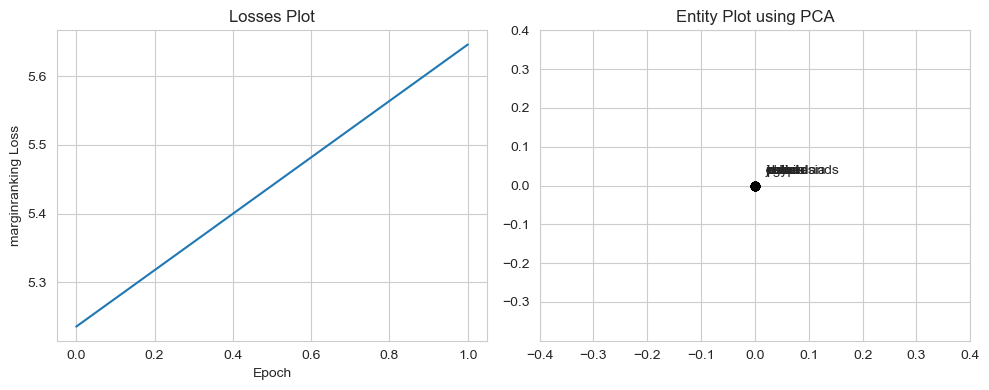

In [64]:
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset
from pykeen.nn import TextRepresentation
from pykeen.models import ERModel

# dataset = get_dataset(dataset="nations")
# entity_representations = TextRepresentation.from_dataset(
#     dataset=dataset,
#     encoder="transformer",
# )
# result = pipeline(
#     dataset=dataset,
#     model=ERModel,
#     model_kwargs=dict(
#         # interaction= "TransE",, # not using ermlpe -> error
#         interaction="ermlpe", # not using ermlpe -> error
        
#         interaction_kwargs=dict(
#             embedding_dim=entity_representations.shape[0],
#         ),
#         entity_representations=entity_representations,
#         relation_representations_kwargs=dict(
#             shape=entity_representations.shape,
#         ),
#     ),
#     training_kwargs=dict(
#         num_epochs=2,
#     ),
# )
# model = result.model
# result.plot()

In [63]:
%%time
from pykeen.models import ERModel
## memory crash on apple silicon in eval
## may have cpu memory leak - when running with more epochs. 

rot_results = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=ERModel, #"TransE",#"TransH", #"TransR",#"TransE",#"TransH", #'RotatE', # aten::complex.out - not supported on mps
     # model= "QuatE",
    # model="convKB", ## To be consistent with the paper, should initialize entity and relation embeddings from TransE.
    # model="RotatE",
    # model="TuckER",
    # epochs=2#35,
    epochs=3,
    # dimensions= 512,
    random_seed=42,
    # device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
    # device="cpu", # "cuda" # runs stably on cuda
    evaluation_fallback = True,
    stopper='early', ## may crash? 
    evaluation_relation_whitelist=subsetPredicates, ## evaluate only on subset of relations
    
    # # ## try adding for Transformer embed
    # model_kwargs=dict(entity_representations_kwargs=dict(
    #         # triples_factory=dataset.training,
    #         base_kwargs=dict(
    #             # shape=embedding_dim,
    #             initializer=entity_initializer,
    #         ))),

    model_kwargs=dict(
        # interaction="ermlpe",
        # interaction="transe",
        interaction_kwargs=dict(
            embedding_dim=entity_representations.shape[0],
        ),
        entity_representations=entity_representations,
        relation_representations_kwargs=dict(
            shape=entity_representations.shape,
        ),
        ),
)

try:
    rot_results.plot()
except:()

## 79/80 [39:19<00:11, 11.65s/epoch, loss=0.0471, prev_loss=0.0475]

INFO:pykeen.triples.triples_factory:keeping 11/24 (45.83%) relations.
INFO:pykeen.triples.triples_factory:keeping 11914/21120 (56.41%) triples.
INFO:pykeen.triples.triples_factory:keeping 11/24 (45.83%) relations.
INFO:pykeen.triples.triples_factory:keeping 11733/21121 (55.55%) triples.
INFO:pykeen.pipeline.api:Using device: None


KeywordArgumentError: ERModel: __init__() missing 1 required keyword-only argument: 'interaction'

In [69]:
testing

TriplesFactory(num_entities=924, num_relations=24, create_inverse_triples=False, num_triples=21120)

In [73]:
# from pykeen.models import *
# ## not working
# model = ERMLPE(
#     triples_factory=tf, #I added - try
#     embedding_dim=768,  # for BERT base
#     entity_initializer=LabelBasedInitializer.from_triples_factory(
#         triples_factory=tf #tf #training, #dataset.training,
#         ,encoder="transformer",
#     ),
# )

0it [00:00, ?it/s]

ValueError: shape does not match: expected torch.Size([924, 768]) but got torch.Size([24, 768])

In [20]:
# results = rot_results

In [21]:
# %%time
# results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model="TuckER",
#     epochs= 2#80
#     ,dimensions= 320,
#     random_seed=42,
#     device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
#     # device="cpu", # "cuda" # runs stably on cuda
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 

#     evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
#     # ,training_kwargs=dict(
#     #     checkpoint_on_failure=True,
#     #     checkpoint_name='my_checkpoint.pt',
#     #     checkpoint_frequency=10,
#     # ),
# )

# try:
#     results.plot()
# except:()
#     ## 
# # 29/80 [24:06<21:44, 25.57s/epoch, loss=0.00466, prev_loss=0.00503]

In [22]:
# results.save_to_directory('./saved/')
# model = torch.load('./saved/trained_model.pkl')

In [23]:
# results

In [24]:
# conv_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model="convKB",
#     epochs=40,
#     dimensions=300, #512,
#     random_seed=42,
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
# )

# try:
#     conv_results.plot()
# except:()
#     ## errorrrrr

In [25]:
# gcn_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model= "AutoSF" #"CompGCN",
#     ,epochs=70,
#     dimensions= 300,
#     random_seed=42,
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
# )
# try:
#     gcn_results.plot()
# except:() # loss=0.0924, prev_loss=0.0923] - autosf , 40 epochs. didn't saturate

In [26]:
# results =gcn_results

` 'training_loop_kwargs': {}, 'evaluator': 'RankBasedEvaluator', 'evaluator_kwargs': {},  'batch_size': 256, `

In [27]:
results.model

NameError: name 'results' is not defined

### Scoring/try - link prediction
* https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target

In [ ]:
query = "Multiple Sclerosis"#"Termination of pregnancy" #"Pregnancy" #"Diet"
df_kg.loc[(df_kg['SUBJECT_NAME']==query)|(df_kg['OBJECT_NAME']==query)].drop_duplicates()

In [ ]:
# df = get_tail_prediction_df(
#     model=result.model,
#     head_label="belgium",
#     relation_label="locatedin",
#     triples_factory=result.training,
#     add_novelties=False,
# )

df_preds_res = predict_target(model=results.model,
    head=query,
    relation="AFFECTS",
    # triples_factory=results.testing,
               triples_factory=tf
    ).df

df_preds_res

In [ ]:
df_diet_known = df_kg.loc[(df_kg['SUBJECT_NAME']=="Diet")&(df_kg['PREDICATE']=="AFFECTS")].drop_duplicates()
df_diet_known

In [ ]:
## known preds
print("Cases in known",df_preds_res.loc[df_preds_res["tail_label"].isin(df_diet_known["OBJECT_NAME"])].shape[0])
min_score_real = df_preds_res.loc[df_preds_res["tail_label"].isin(df_diet_known["OBJECT_NAME"])]["score"].min()
print("lowest scored of real known cases",min_score_real)

In [ ]:
## novel preds
df_novel_cand = df_preds_res.loc[~df_preds_res["tail_label"].isin(df_diet_known["OBJECT_NAME"])]
print(df_novel_cand.shape[0],"total unfil novel candidates")
df_novel_cand.loc[df_novel_cand["score"]>=min_score_real]

* Alt: candidates for what prevents a disease (mayu also want to look at "neagtuively affected by")

In [ ]:
subsetPredicates

In [ ]:
object_cand_query = "Multiple Sclerosis"
NEG_PREDICATES = ["CAUSES",'INHIBITS','PREVENTS', 'TREATS'] # ,'DISRUPTS',  - most common res, includes cytokines
df_preds_res = pd.DataFrame()

for p in NEG_PREDICATES:
    print(p)
    df_temp = predict_target(model=results.model,
        # head=query,
        relation= p,#"PREVENTS", ##subsetPredicates
         tail=object_cand_query,
         triples_factory=tf).df
    df_temp["predicate"]= p
    df_preds_res = pd.concat([df_preds_res,df_temp])
    
df_preds_res = df_preds_res.drop_duplicates(subset=["head_label","predicate"]).round(2)
# df_known = df_kg.loc[(df_kg['OBJECT_NAME']==object_cand_query)&(df_kg['PREDICATE']=="PREVENTS")]
df_known = df_kg.loc[(df_kg['OBJECT_NAME']==object_cand_query)&(df_kg['PREDICATE'].isin(NEG_PREDICATES))]
df_preds_res = df_preds_res.loc[~df_preds_res["head_label"].isin(df_known["OBJECT_NAME"])].sort_values("score",ascending=False)#.head(25)
### filterr by min real score i.e score of known cases
min_score_real = df_preds_res.loc[df_preds_res["head_label"].isin(df_known["SUBJECT_NAME"])]["score"].min()
df_preds_res = df_preds_res.loc[df_preds_res["score"]>=min_score_real]

df_preds_res#.head(25)

In [ ]:
# df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)["head_label"].values.to_clipboard()
df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)

In [ ]:
# df_preds_res.loc[df_preds_res["predicate"]=="TREATS"][["head_label","predicate"]].head(30).to_clipboard()

df_preds_res.loc[df_preds_res["predicate"]=="INHIBITS"][["head_label","predicate"]].head(30)#.to_clipboard()

In [ ]:
df_preds_res[["head_label","predicate"]].head(33)

In [ ]:
df_known